In [1]:
import os
import sys 
import csv
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import sys 

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

import tqdm 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
# !pip install torch torchvision torchaudio numpy pandas pydicom opencv-python-headless matplotlib seaborn tqdm scikit-learn

In [3]:
# pip install efficientnet_pytorch_3d

In [4]:
pytorch3dpath = "EfficientNet-PyTorch-3D"
# pytorch3dpath = "3DAutoencoder/Transformer/EfficientNet-PyTorch-3D"
# einops = "/home/mm510/Dissertation/3DAutoencoder/Transformer/einops"
# einops = "3DAutoencoder/Transformer/einops"

# data_directory = "/data/mm510/UCSF-PDGM-v3/"
data_directory = "/data/"
csv_directory = "UCSF-PDGM-metadata_v2.csv"
# csv_directory = "UCSF-PDGM-metadata_v2.csv"

sys.path.append(pytorch3dpath)
# sys.path.append(einops)

from efficientnet_pytorch_3d import EfficientNet3D


In [6]:
# mri_types = ['_FLAIR','_T1','_T1c','_T2', 'all']
# mri_types = ['_FLAIR']
SIZE = 256
NUM_IMAGES = 64

In [7]:
def filter_non_existent_paths(csv_file, output_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # List to hold indices of rows to be deleted
    rows_to_delete = []

    for index, row in df.iterrows():
        # Extract ID and pad it
        id_num = row['ID'].split('-')[-1].zfill(4)

        # Construct the path
#         path = f"/home/mm510/data/UCSF-PDGM-v3/UCSF-PDGM-{id_num}_nifti"
        path = f"/data/UCSF-PDGM-{id_num}_nifti"

        # Check if path exists
        if not os.path.exists(path):
            # Mark the row index for deletion
            rows_to_delete.append(index)

    # Drop the rows where the path does not exist
    df = df.drop(rows_to_delete)

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

In [8]:
# csv_file = '/home/mm510/Dissertation/3DAutoencoder/Transformer/modified_train_data.csv'  
# output_file = '/home/mm510/Dissertation/3DAutoencoder/Transformer/filtered_output_with_no_non_existant_paths.csv'  
csv_file = 'modified_train_data.csv'  
output_file = 'filtered_output_with_no_non_existant_paths.csv' 
filter_non_existent_paths(csv_file, output_file)

In [9]:
import nibabel as nib
import numpy as np
import cv2
import glob
import re

def extractIDwithoutNifTi(path):
    base_name = os.path.basename(path)
    id_without_nifti = base_name.replace('_nifti', '')
    return id_without_nifti

# img_size=(64, 96, 96)
def load_nii_image(path, img_size=(128, 128, 128), rotate=0):
    nii = nib.load(path)
    data = nii.get_fdata()

    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        if len(data.shape) == 3:
            data = np.array([cv2.rotate(slice, rot_choices[rotate]) for slice in data])
        else:
            data = cv2.rotate(data, rot_choices[rotate])
    
    if len(data.shape) == 3:
        data = np.array([cv2.resize(slice, (img_size[1], img_size[2]), interpolation=cv2.INTER_AREA) for slice in data])
    else:
        data = cv2.resize(data, (img_size[1], img_size[2]), interpolation=cv2.INTER_AREA)

    # Resize depth if necessary
    if data.shape[0] != img_size[0]:
        new_data = np.zeros((img_size[0], img_size[1], img_size[2]))
        depth = min(img_size[0], data.shape[0])
        new_data[:depth] = data[:depth]
        data = new_data

    return data


def load_nii_images_3d(path, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="_FLAIR", split="train", rotate=0):
    # Check if the path exists
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return None  # or handle the non-existent path as needed

    files = sorted(glob.glob(path))
    # print("Files found:", files)

    middle = len(files) // 2
    num_imgs2 = num_imgs // 2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)

    if not files[p1:p2]:
        raise ValueError(f"No files to process in the specified range. Path: {path}")

    # img3d = np.stack([load_nii_image(print(f"Processing file: {f}") or f, img_size=img_size, rotate=rotate) for f in files[p1:p2]])
#     img3d = np.stack([load_nii_image(f, img_size=(64, 96, 96), rotate=rotate) for f in files[p1:p2]])
    img3d = np.stack([load_nii_image(f, img_size=(128, 128, 128), rotate=rotate) for f in files[p1:p2]])


    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d, n_zero), axis=-1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d, 0)

In [10]:
a = load_nii_images_3d("/data/UCSF-PDGM-0004_nifti/UCSF-PDGM-0004_FLAIR.nii")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 1, 128, 128, 128)
0.0 1.0 0.07978620511033317 0.0


In [11]:
print(extractIDwithoutNifTi("/data/UCSF-PDGM-0004_nifti"))

UCSF-PDGM-0004


In [12]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

In [13]:
import pandas as pd

# Load the DataFrame
df = pd.read_csv('UCSF-PDGM-metadata_v2.csv')

# Remove rows with null values in "MGMT status" column
df = df.dropna(subset=['MGMT status'])

# Convert the "MGMT status" column with updated mapping (indeterminate to NaN for removal)
status_mapping = {'negative': 0, 'positive': 1, 'indeterminate': None}
df['MGMT status'] = df['MGMT status'].map(status_mapping)

# Now remove rows where "MGMT status" became None due to mapping (formerly indeterminate)
df = df.dropna(subset=['MGMT status'])

# Convert "MGMT status" to integer to ensure values are 0 and 1, not 0.0 and 1.0
df['MGMT status'] = df['MGMT status'].astype(int)

# Save the modified dataframe to a new CSV file
output_path = 'filtered_output.csv'
df.to_csv(output_path, index=False)


In [14]:
unique_values = df['MGMT status'].unique()
print("Unique values in 'MGMT status':", unique_values)

# Check for null values in the "MGMT status" column
null_count = df['MGMT status'].isnull().sum()
print("Number of null values in 'MGMT status':", null_count)

Unique values in 'MGMT status': [0 1]
Number of null values in 'MGMT status': 0


In [15]:
csv_file = 'filtered_output.csv'  
output_file = 'filtered_output_with_no_non_existant_paths.csv'  
filter_non_existent_paths(csv_file, output_file)

In [16]:
train_df = pd.read_csv("filtered_output_with_no_non_existant_paths.csv")
# display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT status"],
)

In [17]:
unique_values = train_df['MGMT status'].unique()
print("Unique values in 'MGMT status':", unique_values)

Unique values in 'MGMT status': [0 1]


In [18]:
# mri_types = ['_FLAIR','_T1','_T1c','_T2', 'all']
mri_types = ['_FLAIR']
SIZE = 256
NUM_IMAGES = 64

def load_nii_image(path, img_size=(128, 128, 128), rotate=0):
    nii = nib.load(path)
    data = nii.get_fdata()

    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        if len(data.shape) == 3:
            data = np.array([cv2.rotate(slice, rot_choices[rotate]) for slice in data])
        else:
            data = cv2.rotate(data, rot_choices[rotate])
    
    if len(data.shape) == 3:
        data = np.array([cv2.resize(slice, (img_size[1], img_size[2]), interpolation=cv2.INTER_AREA) for slice in data])
    else:
        data = cv2.resize(data, (img_size[1], img_size[2]), interpolation=cv2.INTER_AREA)

    # Resize depth if necessary
    if data.shape[0] != img_size[0]:
        new_data = np.zeros((img_size[0], img_size[1], img_size[2]))
        depth = min(img_size[0], data.shape[0])
        new_data[:depth] = data[:depth]
        data = new_data

    return data


def load_nii_images_3d(path, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="_FLAIR", split="train", rotate=0):
    # Check if the path exists
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return None  # or handle the non-existent path as needed

    files = sorted(glob.glob(path))
    # print("Files found:", files)

    middle = len(files) // 2
    num_imgs2 = num_imgs // 2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)

    if not files[p1:p2]:
        raise ValueError(f"No files to process in the specified range. Path: {path}")

    # img3d = np.stack([load_nii_image(print(f"Processing file: {f}") or f, img_size=img_size, rotate=rotate) for f in files[p1:p2]])
    img3d = np.stack([load_nii_image(f, img_size=(128, 128, 128), rotate=rotate) for f in files[p1:p2]])


    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d, n_zero), axis=-1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d, 0)

class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False, img_size=SIZE, num_imgs=NUM_IMAGES):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
        self.img_size = img_size
        self.num_imgs = num_imgs

    def __len__(self):
        return len(self.paths)
    
    def get_ids(self, index):
        # This method returns the corrected ID for a given index
        original_path = self.paths[index]
        id_num = str(original_path).split('-')[-1] # This splits the ID and takes the last part, which is the number
        padded_id_num = id_num.zfill(4)  # Zero padding to ensure 4 digits
        corrected_id = f"UCSF-PDGM-{padded_id_num}"
        
#         corrected_path = f"/home/mm510/data/UCSF-PDGM-v3/UCSF-PDGM-{padded_id_num}_nifti/UCSF-PDGM-{padded_id_num}_FLAIR.nii"
        corrected_path = f"/data/UCSF-PDGM-{padded_id_num}_nifti/UCSF-PDGM-{padded_id_num}_FLAIR.nii"
        
        if not os.path.exists(corrected_path):
            print(f"Path does not exist for ID {corrected_id}: {corrected_path}. Skipping.")
            return None  # Return None for non-existent paths
        
        return corrected_id


    def __getitem__(self, index):
        # Original path from the dataset
        original_path = self.paths[index]
        # print("Original path in dataset used:", original_path)

        # Correcting the path as per requirement
        # Assuming 'UCSF-PDGM-36' needs to be converted to '/home/mm510/data/UCSF-PDGM-v3/UCSF-PDGM-0366_nifti/UCSF-PDGM-0366_FLAIR.nii'
        # Extract the numerical ID part and add zero padding
        id_num = str(original_path).split('-')[-1]  # This splits the ID and takes the last part, which is the number
        padded_id_num = id_num.zfill(4)  # Zero padding to ensure 4 digits
#         corrected_path = f"/home/mm510/data/UCSF-PDGM-v3/UCSF-PDGM-{padded_id_num}_nifti/UCSF-PDGM-{padded_id_num}_FLAIR.nii"
        corrected_path = f"/data/UCSF-PDGM-{padded_id_num}_nifti/UCSF-PDGM-{padded_id_num}_FLAIR.nii"

        # Constructing the corrected ID
        corrected_id = f"UCSF-PDGM-{padded_id_num}"

        if not os.path.exists(corrected_path):
            print(f"Path does not exist: {corrected_path}. Skipping.")
            return None  # Return None for non-existent paths

        # print("Corrected path used:", corrected_path)
        # print("Corrected ID:", corrected_id)

        # Augmentation logic remains unchanged
        if self.augment:
            rotation = np.random.randint(0, 4)
        else:
            rotation = 0

        # Assuming 'load_nii_images_3d' can handle the corrected path format
        data = load_nii_images_3d(corrected_path, num_imgs=self.num_imgs, img_size=self.img_size, mri_type=self.mri_type, split=self.split, rotate=rotation)

        # Return logic based on whether targets are provided
        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": corrected_id}
        else:
            y = torch.tensor(abs(self.targets[index] - self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y, "id": corrected_id}

In [19]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        mlp_dim = 2048
        for _ in range(depth):
            #print (dim, mlp_dim)
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [20]:
class Model(nn.Module):
    # def __init__(self, *, image_size=(64, 96, 96), patch_size=(8, 8, 8), num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0., emb_dropout=0.):
    #     super().__init__()
    #     assert all(i % p == 0 for i, p in zip(image_size, patch_size)), 'Image dimensions must be divisible by the patch size'
    #     # num_patches = (image_size // patch_size) *(image_size // patch_size)* 2
    #     # num_patches = 3840
    #     # print("patches: ", num_patches)
    #     # patch_dim = channels * patch_size ** 3
    #     num_patches = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1]) * (image_size[2] // patch_size[2])
    #     patch_dim = channels * patch_size[0] * patch_size[1] * patch_size[2]
    #     self.patch_size = patch_size

    #     self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
    #     # print("embeddings: ", self.pos_embedding)
    #     self.patch_to_embedding = nn.Linear(patch_dim, dim)
    #     # print("patch embeddings: ", self.patch_to_embedding)
    #     self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    #     self.dropout = nn.Dropout(emb_dropout)
    #     #print (mlp_dim)
    #     self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
    #     #print (dim)
    #     self.to_cls_token = nn.Identity()

    #     self.mlp_head = nn.Sequential(
    #         nn.LayerNorm(dim),
    #         nn.Linear(dim, mlp_dim),
    #         nn.GELU(),
    #         nn.Dropout(dropout),
    #         nn.Linear(mlp_dim, num_classes),
    #         nn.Dropout(dropout)
    #     )

    def __init__(self, *, image_size=(128, 128, 128), patch_size=(8, 8, 8), num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0., emb_dropout=0.):
        super().__init__()
        # Ensure image_size and patch_size are tuples/lists and have the same length
        assert isinstance(image_size, (tuple, list)) and isinstance(patch_size, (tuple, list)), "image_size and patch_size must be tuples or lists"
        assert len(image_size) == len(patch_size), "image_size and patch_size must have the same length"
        
        # Calculate num_patches by dividing each dimension of image_size by the corresponding dimension of patch_size
        num_patches = 1
        for img_dim, patch_dim in zip(image_size, patch_size):
            assert img_dim % patch_dim == 0, f"Image dimension {img_dim} is not divisible by patch size {patch_dim}"
            num_patches *= (img_dim // patch_dim)
        
        patch_dim = channels * patch_size[0] * patch_size[1] * patch_size[2]
        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        # print("pos embeddings: ", self.pos_embedding)
        # self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.patch_to_embedding = nn.Linear(512, dim)
        # print("patch embeddings: ", self.patch_to_embedding)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
            nn.Dropout(dropout)
        )

    # def forward(self, img, mask=None):
    #     p = self.patch_size

    #     # Squeeze the extra singleton dimension if present
    #     # Check if there's an extra dimension at position 2 (0-indexed) and squeeze it
    #     if img.size(1) == 1 and len(img.shape) == 6:  # Adjust this condition based on where the extra dimension might be
    #         img = img.squeeze(1)  # This changes the shape from [4, 1, 1, 240, 256, 256] to [4, 1, 240, 256, 256]

    #     # Now proceed with your original operation
    #     x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=p, p2=p, p3=p)

    #     # The rest of your forward method remains unchanged
    #     x = self.patch_to_embedding(x)
    #     cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
    #     x = torch.cat((cls_tokens, x), dim=1)
    #     # print(x.shape)
    #     # print(self.pos_embedding.shape)
    #     x += self.pos_embedding
    #     x = self.dropout(x)
    #     x = self.transformer(x)
    #     x = self.to_cls_token(x[:, 0])
    #     return self.mlp_head(x)
        
    def forward(self, img, mask=None):
        p = self.patch_size

        if img.size(1) == 1 and len(img.shape) == 6:  
             img = img.squeeze(1) 


        # expected_shape = (batch_size, channels, depth, height, width) # Adjust as necessary
        # assert img.shape == expected_shape, f"Unexpected img shape: {img.shape}"
        

        # Adjust the rearrange pattern according to the actual dimensions
        # print("Shape before rearrange:", img.shape)
        x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=p[0], p2=p[1], p3=p[2])
        # print("Shape after rearrange:", x.shape)

        x = self.patch_to_embedding(x)
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [21]:
import csv
import os


def init_csv_logger(file_path, headers):
    # Check if the log file already exists
    file_exists = os.path.isfile(file_path)
    
    # Open the file in append mode
    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        
        # Write the header only if the file is new
        if not file_exists:
            writer.writeheader()


In [22]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience, log_file, mri_type):   
        headers = ["epoch", "train_loss", "valid_loss", "valid_auc", "train_time", "valid_time", "mri_type"]
        init_csv_logger(log_file, headers)

        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            with open(log_file, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=headers)
                writer.writerow({
                    "epoch": n_epoch,
                    "train_loss": train_loss,
                    "valid_loss": valid_loss,
                    "valid_auc": valid_auc,
                    "train_time": train_time,
                    "valid_time": valid_time,
                    "mri_type": mri_type
                })

            # if True:
            #if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(torch.sigmoid(outputs).tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-best.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    def load_pretrained_model(self, state_path):
        checkpoint = torch.load(state_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.best_valid_score = checkpoint["best_valid_score"]
        n_epoch = checkpoint["n_epoch"]
        self.info_message("Loaded pretrained model from '{}', starting from epoch {}.", state_path, n_epoch)
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(f"Training for MRI Type: {mri_type}")
    print(df_train.shape, df_valid.shape)
    # display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["ID"].values, 
        df_train["MGMT status"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["ID"].values, 
        df_valid["MGMT status"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=1,
        shuffle=True,
        num_workers=8,pin_memory = True
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=1,
        shuffle=False,
        num_workers=8,pin_memory = True
    )

    model = Model(
    image_size=(128, 128, 128),
    patch_size=(8, 8, 8),
    num_classes=1,
    dim=512,
    depth=2,
    heads=8,
    mlp_dim=1024,
    channels=3,
    dropout=0.1,
    emb_dropout=0.1
)

    model.to(device)

#     checkpoint = torch.load("all-best.pth")
#     model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = torch_functional.binary_cross_entropy_with_logits

    log_file_path = "transformer_training_log.csv"

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        1, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
        log_file=log_file_path,
        mri_type=mri_type
    )
    
    return trainer.lastmodel
#     return model.load_state_dict(checkpoint["model_state_dict"])





if device.type == 'cuda':
        torch.cuda.empty_cache()

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

Training for MRI Type: _FLAIR
(327, 17) (82, 17)
EPOCH: 1
[Epoch Train: 1] loss: 0.6981, time: 232.00 s            
[Epoch Valid: 1] loss: 0.5865, auc: 0.5182, time: 28.00 s
auc improved from inf to 0.5865. Saved model to '_FLAIR-best.pth'
['_FLAIR-best.pth']


In [24]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    # df.loc[:,"MRI_Type"] = mri_type
    # print("these are indexes: ")
    # print("this is the data: ")
    # df.columns
    # print(df.index.values)
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model(
        image_size=(128, 128, 128),
        patch_size=(8, 8, 8),
        num_classes=1,
        dim=512,
        depth=2,
        heads=8,
        mlp_dim=1024,
        channels=3,
        dropout=0.1,
        emb_dropout=0.1
    )
    
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader, 1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(float(tmp_pred))
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"])  # Ensure this is correctly creating a flat list
            
    preddf = pd.DataFrame({"MGMT status": y_pred}, index=ids)  # Directly use ids as index

    return preddf


In [25]:
# df_valid

Predict: _FLAIR-best.pth _FLAIR (82, 16)
unique values in df_valid  [1 0]
               MGMT status
ID                        
UCSF-PDGM-038     0.738747
UCSF-PDGM-358     0.738716
UCSF-PDGM-360     0.738330
UCSF-PDGM-017     0.738584
UCSF-PDGM-538     0.738152
NaN in 'MGMT_pred': 0
              Sex  Age at MRI  WHO CNS Grade  \
ID                                             
UCSF-PDGM-038   M          78              4   
UCSF-PDGM-358   M          57              4   
UCSF-PDGM-360   F          62              4   
UCSF-PDGM-017   M          54              4   
UCSF-PDGM-538   F          41              4   

              Final pathologic diagnosis (WHO 2021)  MGMT status  MGMT index  \
ID                                                                             
UCSF-PDGM-038            Glioblastoma, IDH-wildtype          1.0        16.0   
UCSF-PDGM-358            Glioblastoma, IDH-wildtype          1.0        14.0   
UCSF-PDGM-360            Glioblastoma, IDH-wildtype       

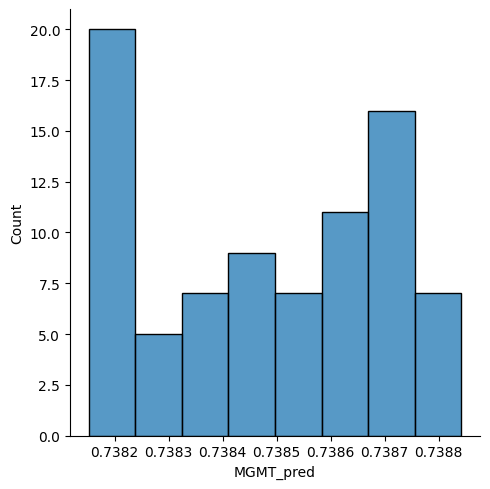

In [26]:
df_valid = df_valid.set_index("ID")
# df_valid['ID']


true_values_column_name = "MGMT status" 

# df_valid["MGMT_pred"] = 0
# for m, mtype in zip(modelfiles,  mri_types):
#     pred = predict(m, df_valid, mtype, "train")
#     df_valid["MGMT_pred"] += pred["MGMT status"]  
# df_valid["MGMT_pred"] /= len(modelfiles)

for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, df_valid, mtype, "train")
    if "MGMT_pred" not in df_valid.columns:
        df_valid["MGMT_pred"] = 0  # Initialize if not exists
    df_valid["MGMT_pred"] += pred["MGMT status"].reindex(df_valid.index).fillna(0)

pred.index = df_valid.index 
df_valid["MGMT_pred"] = pred["MGMT status"]
df_valid["MGMT_pred"] /= len(modelfiles)
print("unique values in df_valid ", df_valid["MGMT status"].unique())



print(pred.head())
print("NaN in 'MGMT_pred':", df_valid["MGMT_pred"].isna().sum())

df_valid["MGMT status"] = df_valid["MGMT status"].astype(float)
df_valid["MGMT_pred"] = df_valid["MGMT_pred"].astype(float)

print(df_valid.head())

auc = roc_auc_score(df_valid["MGMT status"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")


# if true_values_column_name in df_valid:

#     unique_values = df_valid["MGMT_pred"].unique()
#     print("Unique values in 'MGMT_pred':", unique_values)
#     auc = roc_auc_score(df_valid[true_values_column_name], df_valid["MGMT_pred"])  
#     print(f"Validation ensemble AUC: {auc:.4f}")
# else:
#     print(f"Column '{true_values_column_name}' not found in df_valid.")
g = sns.displot(df_valid["MGMT_pred"])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Given data for the models
data = {
    "Models": [
        "Hybrid Loss 1", "Hybrid Loss 1", "Hybrid Loss 1",
        "Hybrid Loss 2", "Hybrid Loss 2", "Hybrid Loss 2",
        "Custom Dice Loss", "Custom Dice Loss", "Custom Dice Loss"
    ],
    "Metrics": [
        "Necrotic", "Edema", "Enhancing",
        "Necrotic", "Edema", "Enhancing",
        "Necrotic", "Edema", "Enhancing"
    ],
    "Values": [
        0.9161, 0.8926, 0.9039,
        0.432, 0.4231, 0.4121,
        0.762, 0.763, 0.738
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to format suitable for the desired plot
# Note that we now use keyword arguments instead of positional arguments.
df_pivot = df.pivot(index='Models', columns='Metrics', values='Values')
df_pivot = df_pivot.reindex(["Necrotic", "Edema", "Enhancing"], axis=1)

# Start plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Create a color map to match the original graph's color scheme
colors = ["#7E57C2", "#FFCA28", "#26A69A"]

# Plot the bars
df_pivot.plot(kind='bar', ax=ax, color=colors)

# Set the x-axis label
ax.set_xlabel("Models", fontsize=12)

# Set the y-axis label
ax.set_ylabel("Dice Coefficients", fontsize=12)

# Set the title of the plot
ax.set_title("Summary of Final Results", fontsize=16)

# Position the legend outside of the plot
ax.legend(title="Target Class Key", bbox_to_anchor=(1, 1), loc='upper left')

# Customize the grid lines
ax.grid(True, which='both', ls='--', lw=.5, color='gray', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
